# Treatment of Covid-19 with Remdesivir - Systematic Review and Meta-Analysis
In this notebook you will be guided through all the steps necessary to conduct this systematic review. We have automated as many steps as possible, but there are still a few steps you need to perform manually. If you are unfamiliar with jupyter notebooks, the way to run code within a cell is by clicking on the cell and clicking on the play button or pressing shift+enter. Please be carefull to precisely do each step as is explained here, or your results might not work properly.
<br>first let's import all necessary python packages.

In [5]:
from bs4 import BeautifulSoup
import copy
import forestplot as fp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from urllib.request import Request, urlopen
from urllib.error import HTTPError

## Search pubmed for appropriate studies
Pubmed is a database which hosts over 35 million scientific publications in the biomedical literature. Most studies on covid are also available free of charge on their website. The first step is to search for relevant publications. We are interested in studies about covid-19 and remdesivir. More specifically Remdesivir must be mentioned in the title of the publication and either covid, corona, or sars-cov-2 must be mentioned in the title or abstract. We are only looking for original studies and not for other meta-analyses on the subject, so we exclude publications which have the term meta-analysis in the title. Please follow the instructions carefully.
1. Click on this [link](https://pubmed.ncbi.nlm.nih.gov/) to visit pubmed.
2. Copy this prompt `(((((((covid[Title/Abstract]) OR (corona[Title/Abstract])) OR (sars-cov-2[Title/Abstract])) OR (sars cov 2[Title/Abstract])) AND (remdesivir[Title])) NOT (Meta Analysis[Title])) NOT (Meta-Analysis[Title])) NOT (Review[Title])` into the search box.
3. Click on save and select <b>all results</b> (not all resutls on page) in selection and <b>Pubmed</b> in format
4. Click on create file and save it under the name <b>search_results.txt</b>

## Automated Filtering
### Filter for Randomized Control Trials
We only want to include randomized control trials in our meta-analysis. We are using a machine-learning tool called robotsearch to filter out only the studies from the pubmed search which used a ranodmized control trial design. If you followed the README.md precisely, you already installed the tool. Please follow the instructions carefully.
1. Move the file search_results.txt that you just downloaded into the robotsearch directory, which is found within the overally project-directory.
2. Open a **new anaconda terminal**. Don't close the one running!
3. `cd` your way into the robotsearch directory within the overall covid_systematic_review directory you downloaded from github. To learn about how to change directories in a terminal [visit here](https://www.lifewire.com/change-directories-in-command-prompt-5185508)
4. If the environment is not activated type `conda activate covid_review`. You will know if your environment is activated by the first phrase in the parantheses. It should say (covid_review).
5. Conda should now be displaing (covid_review) ...\robotsearch>. Run `robotsearch search_results.txt -p` Don't forget the -p-flag, or the results will contain too many false positives you will have to manually check later.

The results are saved in the file search_reults_robotviewer_RCTs.txt. Let's look at the result, by simply running the cell below.

In [2]:
from robotsearch.parsers import ris
file_input = "robotsearch/search_results.txt"
file_result = "robotsearch/search_results_robotreviewer_RCTs.txt"
with open(file_input, 'r', encoding="utf8") as f:
    inp = ris.load(f)
with open(file_result, 'r', encoding="utf8") as f:
    result = ris.load(f)
print("The inital search result has {} articles".format(len(inp)))
print("{} articles were classified as rcts".format(len(result)))

other non numbered
other non numbered
The inital search result has 821 articles
30 articles were classified as rcts


Now we know how many articles were classified as randomized-controlled-trials. We are only going to use the one's that have an open-access. Those that do, have a pmc- identifier associated with the publication. Please execute the cell below to filter out the pmcs.

In [6]:
#extract PMC - they are found in the 'PMC' key.
pmcs = []
for i in range(len(result)):
    if "PMC" in result[i].keys():
        id_raw = result[i]['PMC'][0]
        pmc = id_raw.strip()
        pmcs.append(pmc)

print("{} studies have a pmc-identifier and can be accessed through pubmed open-access".format(len(pmcs)))

26 studies have a pmc-identifier and can be accessed through pubmed open-access


### Filter for response-meassure of interest
Let's reduce the number of publications even further by checking if the articles contain appropriate response-meassures. The response-meassures we are interested in are indicators for mortality or clinical recovery or improvement. The statistical meassures of interest are hazard-ratio or rate-ratio. Every study reports those in the methods section or later in the article. The following cell scans the open-access texts on pubmed and checks if either the terms "mortality" or death or the terms "time to clinical improvement/recovery" are mentioned after the key-word "method". And the check if at the same time the keywords "hazard/rate-ratio" are menetioned after the "method" keyword. Please execute the cell below. It will take a few minutes to run. If you run into errors, try installing mozilla-firefox if you don't have it on your system.

In [8]:
site= "https://www.ncbi.nlm.nih.gov/pmc/articles/{}/"
hdr = {'User-Agent': 'Mozilla/5.0'}
regex_mortality = r"method.+(?:(?:mortality|death)|(?:time to(?:clinical improvement|recovery)))" # the outcome meassure must come after the word method, so it is likey mentioned in the methods or results section
regex_hr = r"method.+(?:hazard|rate)[\s-]ratio"
pmcs_outcome = []
for i in range(len(pmcs)):
    print(i)
    url = site.format(pmcs[i])
    req = Request(url,headers=hdr)
    try:
        page = urlopen(req)
        soup = BeautifulSoup(page)
        if re.search(regex_mortality, soup.prettify(), re.DOTALL|re.IGNORECASE) and re.search(regex_hr, soup.prettify(), re.DOTALL|re.IGNORECASE):
            print(True)
            pmcs_outcome.append(pmcs[i])
    except HTTPError:
        print("httperror")
print("{} articles contain mortality/death or time to clinical improvement or recovery and propper outcome meassure".format(len(pmcs_outcome)))
with open("papers.txt", "w") as f:
    for pmc in pmcs_outcome:
        f.write("%s\n" % "https://www.ncbi.nlm.nih.gov/pmc/articles/{}/".format(pmc))

0
True
1
True
2
True
3
True
4
True
5
6
7
8
True
9
True
10
11
12
13
14
True
15
16
True
17
True
18
True
19
True
20
21
22
True
23
24
25
True
14 articles contain mortality/death or time to clinical improvement or recovery and propper outcome meassure


### Create a spreadsheed to record screening results.
Now that we reduced the number of eligable studies by a very significant amount, we will inspect the remaining studies manually. Run the cell below to create a spreadsheet in which you will document the results of your inspection. You will also get a list of links where you will find the studies.

In [9]:
screening_results = pd.DataFrame(columns = ['pmc', 'non_retracted', 'randomized_controlled', 'adults', 'infected', 'remdesivir_only', 'propper_outcome'])
screening_results['pmc'] = np.array(pmcs_outcome)
screening_results.to_csv("screening_results.csv", index = False, sep = ";")
for i in range(len(pmcs_outcome)):
    print("https://www.ncbi.nlm.nih.gov/pmc/articles/{}/".format(pmcs_outcome[i]))

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7262788/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7745180/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8757570/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7377062/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8279143/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8523116/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7538864/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8490137/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8863204/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7190303/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9017992/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7442954/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8439621/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9278225/


## Manual Screening of Articles
Now that we filtered out the promising studies, we must manually check for their eligibility. Even though we automated the classification as randomized controll trial, we must check for errors. We follow the following protocol. There are certain criteria a publication has to meet in order to be eligable for our final analysis. Open each of the htmls above by clicking on the link or open the file papers.txt. Apply the protocol below very carefully to each study individually. Open the file **screening_results.csv** in a csv-editor of your choice. You will find the file in the main project directory. Note that the separator is a semicolon. <br>
For each criterion listed below, the spreadsheet has a column in which to document, if the study meets the criterion. Type **1** into the cell if the **criterion is met** and **0** if it is **not met**. You can stop checking the remaining criteria for that particular paper, once you coded one criterion as 0 and continue to the next paper, by clicking on the next link in the list above.
### Not retracted
Rarely it happens, that already published articles are retracted for various reasons. This probably won't be the case for the studies here, but we still must check. If the article has been retracted, it shows in a red box on top of the webpage. It's impossible to miss. Code **1** if the article has **not been retracted**.
### Randomized Controlled Trial
Randomized Clinical Trials are those in which patients are assigned randomly to either a group receiving treatment with Remdesivir or a control group, which may be a placebo-group or a standard-treatment. Check the abstract and/or methods secion to check if the studies are randomized control trials. Don't worry about missing this information, the authors will make it very clear if their study is a RCT. **Don't include studies**, in which **both** experimental and control group receive remdesivir but only different dossages. Keywords indicating that a study is not an RCT are: "retrospective" study or analysis or "observational cohort" study.
### Majority Aduls. 
Check if proportion of age above 18 is >95%.
### Participants infected 
Participants must be infected with Covid-19. **No** studies analysing remdesivir as a **prevention** treatment should be included.
### Remdesivir only 
The only difference between treatment- and control-group should be whether patients received remdesivir or not. Some studies investigate the effect of combination treatments of remdesivir with other medications - don't include those studies. Control groups can be placebo or standard-care. If multiple treatments are tested, the study must include a comparison of remdesivir with a placebo or standard care group.
### Propper outcome
To assess the effectiveness of treatment with remdesivir compared to the placebo or standard-care, there must be a propper effect-meassure reported. 
Check if **at least one** of the outcomes **mortality,"time to recovery" or "time to clinical improvement" or equivalent** meassures has one of these meassures associated with it: **hazard-ratio or rate-ratio**. Keep in mind that what the authors declare as primary outcome might not be the primary outcome for this study. You might even have to look into the appendices to retrieve the outcome meassure.

## Extract eligable studies
Make sure to **save the file**. We are going to use the studies that fulfill the above criteria. Execute the cell below to get the studies to be included in the final analysis.

In [11]:
# Please make sure to save your screening_results.csv properly. In Germany the default seperator is semicolon.
df_screening = pd.read_csv("screening_results.csv",sep=";")
df_screening = df_screening.fillna(0)
df_screening["eligable"] = (df_screening.iloc[:,1:].sum(axis = 1)/6).astype(int).astype(bool)
eligable_studies = list(df_screening.loc[df_screening.eligable == True,"pmc"])
result_table = pd.DataFrame(columns = ['pmc', 'ratio_mortality', 'lower_confidence_bound_mortality', 'upper_confidence_bound_mortality', 'p_value_mortality', 'ratio_recovery', 'lower_confidence_bound_recovery', 'upper_confidence_bound_recovery', 'p_value_recovery','sample_size_remdesivir', 'sample_size_control', 'placebo_controlled'])
result_table['pmc'] = np.array(eligable_studies)
result_table.to_csv("result_table.csv", index = False, sep = ";")
print("{} studies were found to be eligable".format(len(eligable_studies)))
for i in range(len(eligable_studies)):
    print("https://www.ncbi.nlm.nih.gov/pmc/articles/{}/".format(eligable_studies[i]))

7 studies were found to be eligable
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7262788/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8757570/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8279143/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8863204/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7190303/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7442954/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8439621/


## Extract Relevant Data
Good job thus far. We have found all the studies which will be included in the final analysis. If you discover that a criterion hasn't been met afterall, simply change the sceening_results.csv file accordingly and rerun the cell above. <br>
Open the file result-table.csv. The separator is semicolon. Open the studies one-by-on by clicking on the corresponding url in the output of the cell above. Please follow the protocol below when you record your findings. If a meassure is missing, leave the cell blank.
### ratio_mortality
Type the value of the hazard- or rate-ratio for mortality. You might have to look into an appendix mentioned in the paper. If mortality-ratios are reported for different time periods, choose the latest. If a study includes hospitalization or death don't include this study for the mortality-meassure, because death itself is the outcome meassure.
### lower_confidence_bound_mortality
The confidence-intervall is usually reported after the ratio. E.g. [95% CI 0·81–1·61] - the example is from an actual paper. You can see that the decimal point is missing. Please type the lower confidence bound (the left one) into the result_table. In the example it would be 0.81.
### upper_confidence bound mortality
Equivalently type the upper confidence bound (the right one) into the table. In the example it would be 1.61.
### p_value_mortality
Type the p-value into the result-table. It is usually documented right next to the confidence interval. If it isn't you have to look a bit in the results section. If there is only a confidence interval reported, leave the column p-value empty.
### ratio_recovery
Different studies use different recovery-meassures. You should only report one. If a ratio is reported for time to recovery use that one, if not, look if there is time to improvement or aleviation of symptoms or an equivalent meassure.
Type the value of the hazard- or rate-ratio into the cell. You might have to look into an appendix mentioned in the paper.
### lower_confidence_bound_recovery
The confidence-intervall is usually reported after the ratio. E.g. [95% CI 0·81–1·61] - the example is from an actual paper. You can see that the decimal point is missing. Please type the lower confidence bound (the left one) into the result_table. In the example it would be 0.81.
### upper_confidence_bound_recovery
Equivalently type the upper confidence bound (the right one) into the table. In the example it would be 1.61.
### p_value_recovery
Type the p-value into the result-table. It is usually documented right next to the confidence interval. If it isn't you have to look a bit in the results section. If there is only a confidence interval reported, leave the column p-value empty.
### sample-sizes
Type the sample-sizes for the remdesivir group and the control-group seperately.
### placebo
check if the control group recevided a placebo or not. If the control-group received a placebo type 1 into the column and else type 0.
### save the file.


## Data Analysis
The analysis is almost done. The manual work is over. It's time to look at our results. We have two effects we want to evaluate - Does remdesivir reduce mortality and does remdesivir reduce the time to recovery or clinical improvement. Run the cells below to get the results.
### Preprocess Data
This function calculates the pooled effect for multiple studies. It utilitzes the fixed-effects model.

In [12]:
def pooled_effect(df):
    df_effect = copy.copy(df)
    df_effect = df_effect.iloc[:,1:4]
    df_effect.columns = ["ratio", "l", "u"]
    def st_error(upper, lower):
        return  (np.log(upper) - np.log(lower))/3.92
    def weight(se):
        return 1/(se**2)
    
    df_effect["se"] = df_effect.apply(lambda row : st_error(row["u"], row["l"]), axis = 1)
    df_effect["weight"] = df_effect.apply(lambda row : weight(row["se"]), axis = 1)
    sum_of_weights = df_effect["weight"].sum()
    pooled_effect = np.exp((np.log(df_effect["ratio"])*df_effect["weight"]).sum()/sum_of_weights)
    pooled_se = (1/sum_of_weights)**0.5
    pooled_lower_bound = np.exp(np.log(pooled_effect) - 1.96*pooled_se)
    pooled_upper_bound = np.exp(np.log(pooled_effect) + 1.96*pooled_se)
    return pooled_effect, pooled_lower_bound, pooled_upper_bound
                                      
    

In [61]:
df_results = pd.read_csv("result_table.csv", sep= ";")
df_mortality = df_results[["pmc", "ratio_mortality", "lower_confidence_bound_mortality", "upper_confidence_bound_mortality", 
                          "p_value_mortality", "sample_size_remdesivir", "sample_size_control", "placebo_controlled"]]
df_mortality = df_mortality.dropna(subset=['ratio_mortality'])
df_mortality = df_mortality.reset_index(drop=True)
df_improvement = df_results[["pmc", "ratio_recovery", "lower_confidence_bound_recovery", "upper_confidence_bound_recovery", 
                          "p_value_recovery", "sample_size_remdesivir", "sample_size_control", "placebo_controlled"]]
df_improvement = df_improvement.dropna(subset=["ratio_recovery"])
df_improvement = df_improvement.reset_index(drop=True)
row_pooled_mortality = ["mortality_pooled"] + list(pooled_effect(df_mortality))  +[np.nan,df_mortality["sample_size_remdesivir"].sum(),df_mortality["sample_size_control"].sum(),np.nan] 
df_mortality.loc[len(df_mortality)] = row_pooled_mortality
row_pooled_improvement = ["improvement_pooled"] + list(pooled_effect(df_improvement))  +[np.nan,df_improvement["sample_size_remdesivir"].sum(),df_improvement["sample_size_control"].sum(),np.nan] 
df_improvement.loc[len(df_improvement)] = row_pooled_improvement
df_improvement_processed = pd.DataFrame(columns = ["study", "response","effect-size", "ll", "hl", "p", "n_remdesivir", "n_control", "placebo"])
df_improvement_processed[["study", "effect-size", "ll", "hl", "p", "n_remdesivir", "n_control", "placebo"]] = df_improvement[
    ["pmc", "ratio_recovery", "lower_confidence_bound_recovery", "upper_confidence_bound_recovery", "p_value_recovery", "sample_size_remdesivir", "sample_size_control","placebo_controlled"]]
df_improvement_processed["response"] = "recovery"
df_improvement_processed ["placebo"] = df_improvement_processed["placebo"].astype(bool).astype(str)
df_improvement_processed["N"] = df_improvement_processed.n_remdesivir + df_improvement_processed.n_control
df_improvement_processed = df_improvement_processed.sort_values(by=["N"], ascending=False)
df_improvement_processed = df_improvement_processed.reset_index(drop=True)
df_improvement_processed["study"] = df_improvement_processed["study"]+ " r"
df_mortality_processed = pd.DataFrame(columns = ["study", "response","effect-size", "ll", "hl", "p", "n_remdesivir", "n_control", "placebo"])
df_mortality_processed[["study", "effect-size", "ll", "hl", "p", "n_remdesivir", "n_control", "placebo"]] = df_mortality[
    ["pmc", "ratio_mortality", "lower_confidence_bound_mortality", "upper_confidence_bound_mortality", "p_value_mortality", "sample_size_remdesivir", "sample_size_control","placebo_controlled"]]
df_mortality_processed["response"] = "mortality"
df_mortality_processed ["placebo"] = df_mortality_processed["placebo"].astype(bool).astype(str)
df_mortality_processed["N"] = df_mortality_processed.n_remdesivir + df_mortality_processed.n_control
df_mortality_processed = df_mortality_processed.sort_values(by=["N"], ascending=False)
df_mortality_processed = df_mortality_processed.reset_index(drop=True)
df_mortality_processed["study"] = df_mortality_processed["study"]+ " m"
df_total = pd.concat([df_improvement_processed, df_mortality_processed])
df_total = df_total.reset_index(drop=True)
df_total["N"] = df_total["N"].astype("O")
for i in range(len(df_total)):
    if df_total.at[i,"study"] == "improvement_pooled r":
        df_total.at[i,"study"] = "recovery pooled"
    if df_total.at[i,"study"] == "mortality_pooled m":
        df_total.at[i,"study"] = "mortality pooled"
df_total

,study,response,effect-size,ll,hl,p,n_remdesivir,n_control,placebo,N
0,recovery pooled,recovery,1.226016,1.108166,1.356399,NaN,1585,1500,True,3085
1,PMC7262788 r,recovery,1.290000,1.120000,1.490000,0.001,541,521,True,1062
2,PMC8439621 r,recovery,1.110000,0.870000,1.420000,0.390,414,418,False,832
3,PMC8757570 r,recovery,1.410000,0.730000,2.690000,NaN,279,283,True,562
4,PMC7442954 r,recovery,1.160000,0.930000,1.430000,NaN,193,200,False,393
5,PMC7190303 r,recovery,1.230000,0.870000,1.750000,0.240,158,78,True,236
6,mortality pooled,mortality,0.842770,0.712580,0.996747,NaN,1402,1401,True,2803
7,PMC8863204 m,mortality,0.880000,0.720000,1.070000,NaN,634,647,False,1281
8,PMC7262788 m,mortality,0.730000,0.520000,1.030000,NaN,541,521,True,1062
9,PMC7442954 m,mortality,0.760000,0.170000,3.400000,NaN,193,200,False,393


### Significance Test for pooled effects.
We are going to use the confidence-interval significance test. We are checking if the value 1 is within the 95% Confidence Interval. The value of 1 indicates that the groups do not differ with respect to the outcome-meassure.

In [62]:
improvement_ll = df_total.loc[df_total.study == "recovery pooled","ll"].values[0]
improvement_hl = df_total.loc[df_total.study == "recovery pooled","hl"].values[0]
print("confidence interval for clinical recovery or improvement [{},{}]".format(improvement_ll,improvement_hl))
if improvement_ll > 1:
    print("Treamtment with remdesivir is associated with a significantly faster recovery or clinical improvement")
elif improvement_hl < 1:
    print("Treamtment with remdesivir is associated with a significantly slower recovery or clinical improvement")
else:
    print("Treamtment with remdesivir is not associated with a significantly faster recovery or clinical improvement")

mortality_ll = df_total.loc[df_total.study == "mortality pooled","ll"].values[0]
mortality_hl = df_total.loc[df_total.study == "mortality pooled","hl"].values[0]
print("confidence interval for clinical recovery or improvement [{},{}]".format(mortality_ll,mortality_hl))
if mortality_hl < 1:
    print("Treamtment with remdesivir is associated with a significantly lower mortality-rate")
elif mortality_ll > 1:
    print("Treamtment with remdesivir is associated with a significantly higher mortality-rate")
else:
    print("Treamtment with remdesivir is not associated with a significantly faster recovery or clinical improvement")

confidence interval for clinical recovery or improvement [1.108166366518543,1.3563993554322566]
Treamtment with remdesivir is associated with a significantly faster recovery or clinical improvement
confidence interval for clinical recovery or improvement [0.7125795963145016,0.996747270142469]
Treamtment with remdesivir is associated with a significantly lower mortality-rate


### Create Forestplot
Now that we know if the pooled outcome was significant or not, let's visualize our results with a forest plot.

<AxesSubplot: xlabel='ratio'>

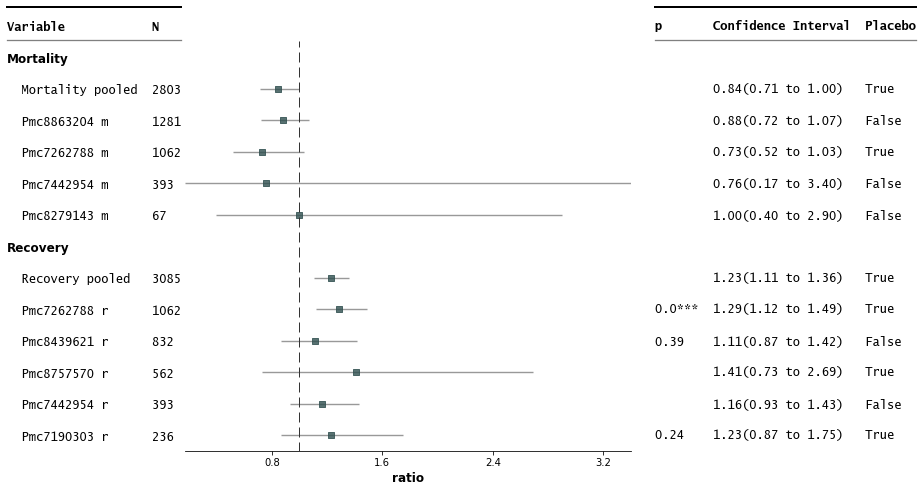

In [65]:
fp.forestplot(df_total,  # the dataframe with results data
              estimate="effect-size",  # col containing estimated effect size 
              ll="ll", hl="hl",  # lower & higher limits of conf. int.
              varlabel="study",  # column containing the varlabels to be printed on far left
              capitalize="capitalize",  # Capitalize labels
              pval="p",  # column containing p-values to be formatted
              annote=["N"],  # columns to report on left of plot
              annoteheaders=["N"],  # ^corresponding headers
              rightannote=["formatted_pval", "est_ci", "placebo"],  # columns to report on right of plot 
              right_annoteheaders=["p","Confidence Interval","Placebo"],  # ^corresponding headers
              groupvar = "response",
              group_order=["mortality", "recovery"],    
              xlabel="ratio",  # x-label title
              xline = 1,
              xlinestyle = (1, (10, 5)),
              figsize = (8,8),
             table=True)